In [37]:
import numpy as np
from numpy import log, pi

from scipy.stats import norm, gamma
from scipy.special import loggamma

from seaborn import kdeplot
import seaborn as sns

import matplotlib.colors as colors
from matplotlib import cm
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pymc3 as pm
from pymc3.stats import summary

## Before submitting
1. Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

2. Make sure that no assertions fail or exceptions occur, otherwise points will be subtracted.

4. Please submit only the `*.ipynb` file.

5. Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE". Edit only between `YOUR CODE HERE` and `END YOUR CODE`.

6. Make sure to use Python 3, not Python 2.

Fill your group name and collaborators below:

In [2]:
GROUPNAME = "GROUP 17"
COLLABORATORS = "Aleksandra Kudaeva, Tor Istvan Stadler Kjetså"

$\newcommand{\lrg}{\large{}}$
$\newcommand{\ltxt}[1]{\lrg\text{#1}}$
$\newcommand{\nfr}[2]{ {}^{#1}/_{#2} }$

### Exercise 1.1: Student's T distribution (5 pts)

* Implement robust studentsT pdf function
* Ensure that the $\nu$ and $\sigma$ parameters are positive

### Student's T distribution PDF
<hr>
$$\lrg{
p(x | \mu, \sigma, \nu) = \frac{\Gamma(\frac{\nu + 1}{2})}{\Gamma(\nfr{\nu}{2})} \Big({\pi\nu\sigma^2} \Big)^{-\frac{1}{2}} \bigg( 1 + \frac{(x - \mu)^2}{\nu\sigma^2}\bigg)^{-\frac{\nu +1}{2}}
}$$

In [3]:
def studentsT(x, mu, sigma, nu):
    # YOUR CODE HERE
    logpdf = loggamma((nu+1)/2)-loggamma(nu/2)-1/2*(np.log(pi*nu)) - np.log(sigma)- ((nu+1)/2)*np.log(1+((x-mu)**2)/(nu*(sigma**2)))
    
    return np.exp(logpdf)

### Exercise 1.2: Student's T distribution (5 pts)

* Plot Stundent's T pdf for diffrent gaussianity values $\nu$

Your plot should look like:

<img src='stT.png'>


In [4]:
x = np.linspace(-10,30,100)

mu = 10
sigma = 5

twos = np.array(9*[2.])
nus = np.power(twos,np.arange(-3,6))

f,axis = plt.subplots(3,3,figsize=(16,12), sharey=True)

n=0
for i in range(3):
    for j in range(3):
        ax = axis[i,j]
        nu = nus[n]
        
        # YOUR CODE HERE
        pdf = studentsT(x, mu, sigma, nu)
        
        ax.plot(x, pdf, linestyle = '--', color = 'g', label = 'St($\mu$, $\sigma$, \nu =' + str(nu))        
        ax.fill_between(x, 
                        pdf, 
                        color = 'g', 
                        alpha = 0.2)
        ax.plot(x, norm.pdf(x, mu, sigma), color = 'red', label = 'N($\mu$, $\sigma$)')       
        ax.axvline(mu, linestyle = '--', color = 'b', label = 'E[x] = $\mu$' )

        n+=1
        ax.grid(axis='x')
        ax.legend(loc=1, fontsize=12)
        ax.set_ylim(0,0.1)
axis[0,1].set_title('Student\'s T vs. Gaussian distribution', fontsize=15)
plt.tight_layout()

In [5]:
def get_colors(X, min_val=None, max_val=None):
    if min_val is None:
        min_val = X.min()
    if max_val is None:
        max_val = X.max()
    cNorm  = colors.Normalize(vmin=min_val, vmax=max_val)
    cmap =  cm.ScalarMappable(norm=cNorm, cmap=cm.rainbow)
    return cmap.to_rgba(X)

### Exercise 2.1: Gamma and Normal samples (5 pts)

* Draw $N=10000$ samples from Gamma distribution for the given $a$ and $b$ values


* Compute pdf value for each of the sampled points 


* Create 1-dim data representation plot with color as pdf values and rainbow colormap


* Depict first moment of the Gamma distribution

Your plot should look like:

<img src='gam.png' width=500>

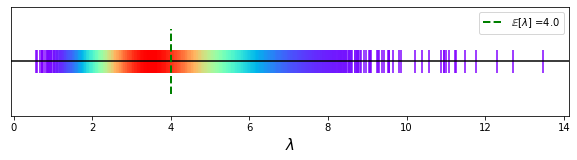

In [6]:
N = 10000
a = 8
b = 2
E_lambd = a/b
scale = 1./b

# YOUR CODE HERE
lambdas = gamma.rvs(a, scale = scale, size = N)
pdfs = gamma.pdf(lambdas, a, scale = scale)


col = get_colors(pdfs)
plt.figure(figsize=(10,2))
plt.scatter(lambdas, np.zeros(len(pdfs)), marker='|',  c=col,s=500)
plt.axhline(0,color='k')
plt.axvline(E_lambd,ls='--', color='g' ,ymin=0.2, ymax=0.8, linewidth=2, label='$\\mathbb{E}[\\lambda]$ ='+f'{a/b:.2}')
plt.xlabel('$\\lambda$', fontsize=15)
plt.yticks([])
_=plt.legend()

* Draw $N=10000$ samples from Normal distribution for the given $\sigma$ value.


* Compute pdf value for each of the sampled points 


* Create 1-dim data representation plot with color as pdf values and rainbow colormap


* Depict first moment of the Normal distribution

Your plot should look like:

<img src='normal.png' width=500>

In [7]:
m_0 = 2
sigma =1./E_lambd**0.5

# YOUR CODE HERE
mus = norm.rvs(loc = m_0, scale = sigma, size = N)
pdfs = norm.pdf(mus, loc = m_0, scale = sigma)

col = get_colors(pdfs)
plt.figure(figsize=(10,2))
plt.scatter(mus, np.zeros(len(pdfs)), marker='|',  c=col,s=500)
plt.axhline(0,color='k')
plt.axvline(m_0,ls='--', color='g' ,ymin=0.2, ymax=0.8, linewidth=2, label='$\\mathbb{E}[\\mu]$ ='+str(m_0))
plt.xlabel('$\\mu$', fontsize=15)
plt.yticks([])
_=plt.legend()

### Exercise 2.2: Normal-gamma PDF (5 pts)

* Implement Normal-gamma distribution as a product of two pdf functions (norm and gamma) from scipy.stats package

### Normal-gamma distribution

$$\lrg{
p(\mu,\lambda| m, \beta, a, b ) = \text{NormGam}(\mu,\lambda | m,\beta,a,b) = \mathcal{N}(\mu | m, (\beta\lambda)^{-1}) \text{Gamma}(\lambda| a,b)
}$$

$$\boxed{\lrg{\text{NormGam}(\mu,\lambda | m,\beta,a,b)=
\Big(\frac{\beta\lambda}{2\pi}\Big)^{-\frac{1}{2}}\exp\Big(-\frac{\beta\lambda\cdot(\mu - m)^2}{2}\Big) \cdot \frac{b^a}{\Gamma(a)}\lambda^{(a - 1)}\exp{(-b\lambda)}
}}$$

In [111]:
def normal_gamma(mu, lambd, m_0=0, beta=1, a=1, b=1):
    # YOUR CODE HERE
    #logpdf = -0.5*(np.log(beta*lambd)-np.log(2*pi)) - (beta*lambd*(mu-m_0)**2)/2 + a*np.log(b) - loggamma(a) + (a-1)*np.log(lambd) - b*lambd
    pdf = norm.pdf(mu, m_0, (1 / (beta*lambd)))*gamma.pdf(lambd, a, scale = 1 / b)
    return pdf
    #return np.exp(logpdf)

### Exercise 2.3: Normal-gamma density plot (10 pts)

* Create a plot of the Normal-gamma density for given $\beta$ values within the given range

* Depict different density regions as a color bar.

Your plot should look like:

<img src='col.png' width=1000>

In [112]:
mus = np.linspace(-6, 10, 100)
lambdas = np.linspace(1e-2, 8, 100)
M, L = np.meshgrid(mus, lambdas)

In [113]:
betas = [0.1, .25, .5]

f,axis = plt.subplots(1, len(betas), figsize=(16,6), sharey=True, sharex=False)

for i in range(len(betas)):
    ax = axis[i]
    beta = betas[i]
    
    # YOUR CODE HERE
    pdf = normal_gamma(M, L, beta = beta, a = 8, b = 2, m_0 = 2)
    
    ccont = ax.contourf(M, L , pdf, cmap = cm.rainbow, levels = 8, alpha = 0.7)
    f.colorbar(ccont, ax = ax, orientation = "horizontal")
    
ax.set_xlabel('$\\mu$',fontsize=15)
ax.set_ylabel('$\\lambda$',fontsize=20, rotation=0, labelpad=20)
axis[1].set_title('Normal-gamma PDF', fontsize=20)
plt.tight_layout()

### Exercise 2.4: Normal to Normal-gamma conjugacy ( 10 pts)


* Use random state $= 42$ for all random sampling functions in this exercise


* Draw lambda value from Gamma distribution for given $a$ and $b$ values


* Generate $N=25$ toy data points drown from Normal distribution with given mean $\mu = m_0$ and scale value $\large{\sigma = \frac{1}{\sqrt\lambda} }$


In [114]:
# Toy data
N = 25

m_0 = 2
a_true = 4
b_true = 2
scale = 1/b_true

# YOUR CODE HERE
lambd = gamma.rvs(a_true, scale= scale,random_state=42)
sigma = 1/np.sqrt(lambd)
toy_data = norm.rvs(m_0, sigma, size = N, random_state =42)

print(f'True lambda: {lambd:.2f}')
print(f'True sigma: {sigma:.2f}')
print("True mean: ", m_0)

True lambda: 2.35
True sigma: 0.65
True mean:  2



* Depict your samples data as 1-dim plot together with the histogram density plot


* Compute and depict empirical mean of your data

<img src='toy.png' width=800>

In [158]:
f,axis = plt.subplots(1, 2, figsize=(12,4), sharey=False, sharex=False)

ax = axis[0]

# YOUR CODE HERE
y = np.ones(np.shape(toy_data))
ax.axhline(1, color = 'black')
ax.plot(toy_data, y, '|', ms = 30, linewidth = 5)
#ax.plot(np.mean(toy_data), 1, '|',ms = 60, color = 'r', linewidth = 3)
ax.vlines(np.mean(toy_data),0.80, 1.20, color = 'r', linestyle = '--', label = f'Emp mean: {np.mean(toy_data):.2f}', linewidth =2)
ax.set_ylim([0.5,1.5])
ax.set_yticks([])
ax.set_title('1-dim samples')
ax.legend()
ax.set_yticks([])

ax = axis[1]

# YOUR CODE HERE
lin = np.linspace(0,4,25)
plt.hist(toy_data,bins=20,rwidth=0.8, density=True, color='b', alpha=0.3)
_=sns.kdeplot(toy_data,color='k')
ax.axvline(np.mean(toy_data), color = 'r', linestyle = '--', label = f'Emp mean: {np.mean(toy_data):.2f}', linewidth =2)
#ax.plot(lin, norm.pdf(lin, m_0, sigma), color = 'black')

ax.legend(loc=1)

plt.tight_layout()

### Exercise 2.5: Normal-gamma posterior (5 pts)

<hr>


* Implement Normal-gamma posterior function as a function of $\mu$ and $\lambda$ for given data $X$ and hyperparameters $m_0, \beta_0, a_0, b_0$



* Your function should return computed pdf values, first moment of $\mu$ and $\lambda$



$$\lrg{
p(\mu,\lambda | X, m_0, \beta_0, a_0, b_0) = \text{NormGam}(\mu, \lambda | m, \beta, a, b ),\ \text{where}
}$$

$$\boxed{\lrg{
\beta =  \beta_0 + N, \quad m = \frac{N\overline{X} + \beta_0m_0}{\hat{\beta}}, \quad a = a_0 + \nfr{N}{2},\quad b = b_0 + \frac{1}{2}\bigg( \sum_{n=1}^N (X_n - \overline{X})^2 + \frac{N\beta_0(\overline{X} - m_0)^2}{\hat\beta}\bigg),\\  \quad \overline{X} = \frac{1}{N}\sum_{n=1}^N X_n
}}$$

$$\lrg{
\mathbb{E}[\mu] = m,\quad \mathbb{E}[\lambda] = \frac{a}{b}
}$$ 

In [129]:
def posterior(mu, lambd, X, m_0, beta_0, a_0, b_0):
    N = len(X)
    
    # YOUR CODE HERE
    beta = beta_0 + N
    m = (X.mean() + beta_0 * m_0)/beta
    a = a_0 + N/2
    b = b_0 + 0.5*(np.sum((X-X.mean())**2)+N*beta_0*((X.mean()-m_0)**2)/beta)
    
    #produces a wrong result when I set it to m
    Em = X.mean()
    El = a/b
    pdfs = normal_gamma(mu = mu, lambd = lambd, m_0=X.mean(), beta=beta, a=a, b=b)
    
    return pdfs, Em, El

### Exercise 2.5: Normal-gamma posterior density (5 pts)


* Depict Normal-gamma posterior density region for the given region as a filled countour plot


* Depict first moments of $\mu$ and $\lambda$ from your posterior.

Your plot should look like:


<img src='post.png' width=500>

In [130]:
mus = np.linspace(1.825, 1.98, 100)

lambdas = np.linspace(1, 4.5, 100)
M, L = np.meshgrid(mus, lambdas)

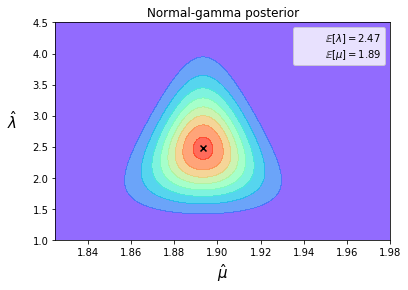

In [131]:
beta_0 = 1
a_0 = 4
b_0 = 2
X = toy_data
xm = X.mean()

fig,ax=plt.subplots(1,1)

# YOUR CODE HERE
pdf,Em,El  = posterior(mu = M, lambd = L, X = X, m_0 = m_0, beta_0 = beta_0, a_0 = a_0, b_0 = b_0)
ccont = ax.contourf(M, L , pdf, cmap = cm.rainbow, levels = 8, alpha = 0.7)

ax.set_ylabel('$\\hat\lambda$', rotation=0, fontsize=15, labelpad=20)
ax.set_xlabel('$\\hat\mu$',fontsize=15)
ax.set_title('Normal-gamma posterior')
ax.scatter(Em,El,marker='x', color='k')
ax.scatter(Em,El, alpha=0, label='$\\mathbb{E}[\lambda]=$'+f'{El:.2f}'+'\n'+'$\\mathbb{E}[\mu] = $'+f'{Em:.2f}')
_=ax.legend()

In [132]:
print(f'True lambda:\t{lambd:.2f}\t'+f'| Est lambda:\t{El:.2f}')
print(f'True sigma:\t{sigma:.2f}\t'+f'| Est sigma:\t{1/El**0.5:.2f}')
print(f"True mean:\t{m_0}\t" +f'| Est mean:\t{Em:.2f}')

True lambda:	2.35	| Est lambda:	2.47
True sigma:	0.65	| Est sigma:	0.64
True mean:	2	| Est mean:	1.89


### Exercise 3.1: Normal to Normal-gamma by sampling (10 pts)


* Define a probabilistic model using pyMC3 package


* Use _Gamma_ function for lambda parameter with $a = b = 1$


* Use _Deterministic_ function to compute scale $\sigma$


* Use _Normal_ function for mean $\mu$ with $mu = 0$ and $sd = 10$


* Use _Normal_ function to define your likelihood 

In [196]:
gauss_gam = pm.Model()

with gauss_gam:
    # YOUR CODE HERE
    lambd = pm.Gamma('lambd', alpha=1, beta=1)
    sigma = pm.Deterministic('sigma', 1/lambd)
    mu = pm.Normal('mu', mu=0, sigma=10)
    likelihood = pm.Normal('likelihood', mu=mu, sigma=sigma, observed=X)

* Draw 10000 posterior samples from your prob model with 1000 tune steps and 4 chains 

In [187]:
with gauss_gam:
    
    # YOUR CODE HERE
    p_samples = pm.sample(10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, lambd]
Sampling 4 chains, 0 divergences: 100%|███████████████████████████████████████| 42000/42000 [08:45<00:00, 80.00draws/s]


### Exercise 3.2: Analysis of the posterior samples (5 pts)

* Depict your collected trace with _traceplot_ function

Your plot should look like:

<img src='trace.png' width=800>

In [188]:
# YOUR CODE HERE
pm.traceplot(p_samples)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001B49B0A5A48>,
      dtype=object)

* Show your trace summary

<img src='summary.png' width=500>

In [189]:
# YOUR CODE HERE
pm.stats.summary(p_samples)

mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean   ess_sd  \
mu     1.891  0.134   1.639    2.143      0.001    0.001   29462.0  29462.0   
lambd  1.569  0.229   1.149    2.001      0.001    0.001   29376.0  29344.0   
sigma  0.652  0.100   0.481    0.838      0.001    0.000   28202.0  27048.0   

       ess_bulk  ess_tail  r_hat  
mu      29774.0   24574.0    1.0  
lambd   29239.0   25700.0    1.0  
sigma   29239.0   25700.0    1.0

* Show your posterior plot using _plot_posterior_ function

<img src='p_post.png' width=800>

In [190]:
# YOUR CODE HERE
pm.plot_posterior(p_samples)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001B4A0963308>,
      dtype=object)

### Exercise 3.3: Posterior predictive approximation (5 pts)

* Collect 5000 posterior samples by using _sample_posterior_predictive_ function

In [193]:
with gauss_gam:
    # YOUR CODE HERE
    samples = pm.sample_posterior_predictive(p_samples, samples=5000)

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 610.68it/s]


* Create approx pedictive function as histogram density plot with kde function

Your plot should look like:

<img src='pred.png' width=400>

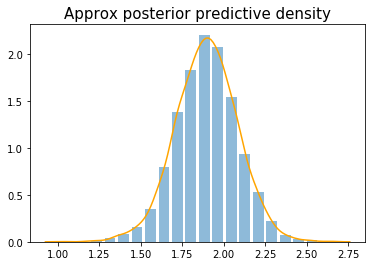

In [192]:
# YOUR CODE HERE
plt.hist([n.mean() for n in samples['likelihood']], bins=20, rwidth=0.8, alpha=0.5, density = True)
_=sns.kdeplot([n.mean() for n in samples['likelihood']],color='orange')

_=plt.title('Approx posterior predictive density', fontsize=15)

* Depict posterior samples for $\mu$ and $\lambda$ as a scatter plot.

Your plot should look like:

<img src='smpl.png' width=400>

In [249]:
# YOUR CODE HERE
fig,ax=plt.subplots(1,1)

m = [n.mean() for n in p_samples['mu']]
l = [n.mean() for n in p_samples['lambd']]

m_mean = np.mean(m)
l_mean = np.mean(l)

ax.plot(m,l, 'o', alpha=0.01)
ax.scatter(m_mean,l_mean, marker='x', color='k', label='$\\mathbb{E}[\lambda]=$'+f'{l_mean:.2f}'+'\n'+'$\\mathbb{E}[\mu] = $'+f'{m_mean:.2f}')
_=ax.legend()


### Exercise 3.4: Posterior density estimation (5 pts)


* Estimate posterior density by using _gaussian_kde_ function from scipy package.


* Depict your Normal-gamma posterior approximation as filled contour plot for the given range.

Your plot should look like:

<img src='kde.png' width=600>


TypeError: float() argument must be a string or a number, not 'gaussian_kde'

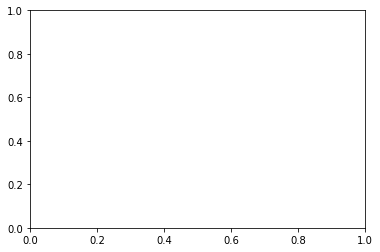

In [278]:
from scipy.stats import gaussian_kde

mus = np.linspace(1.825, 1.98, 100)
lambdas = np.linspace(1, 4.5, 100)
M, L = np.meshgrid(mus, lambdas)


values = np.vstack([p_samples['mu'], p_samples['lambd']])
# YOUR CODE HERE
pdf = gaussian_kde(values)
ccont = plt.contourf(M, L , pdf, cmap = cm.rainbow, levels = 8, alpha = 0.7)

In [ ]:
fig,axis=plt.subplots(1,2, figsize=(12,8), sharex=True)

ax = axis[0]

# YOUR CODE HERE

ax.scatter(Em,El,marker='x', color='k')
ax.scatter(Em,El, alpha=0, label='$\\mathbb{E}[\lambda]=$'+f'{El:.2f}'+'\n'+'$\\mathbb{E}[\mu] = $'+f'{Em:.2f}')
ax.legend()

ax = axis[1]

# YOUR CODE HERE

ax.set_title('Normal-Gamma posterior approximation')
ax.scatter(m_mean,l_mean, color='k', marker='x', label='$\\mathbb{E}[\lambda]=$'+f'{l_mean:.2f}'+'\n'+'$\\mathbb{E}[\mu] = $'+f'{m_mean:.2f}')
_=ax.legend()

### Exercise 4.1: Linear regression by sampling (5 pts)


* Given $N=100$ toy data points


In [ ]:
N = 100
X = np.linspace(-2,3,N)
f1 = np.sin
D = f1(X) + norm.rvs(scale=0.1, size=N)
plt.scatter(X,D,color='k', alpha=0.5, label='data')
plt.plot(X,f1(X), 'r-', label='true f')
_=plt.legend(loc=2)

* Define a probabilistic model using pyMC3 package


* Use _MvNormal_ function for polynomial weights with $\mu = 0$ and covariance matrix as 4-dimensional identity matrix.


* User _Gamma_ function for prior over the observation noise scale value $\sigma$.


* Use _Normal_ function to define your likelihood.



In [ ]:
from pymc3.math import dot

H = 4 
X_pow = X[:,None]**np.arange(H)[None]
X_pow.shape

reg = pm.Model()

with reg:
    # YOUR CODE HERE
    cov = #identity matrix
    weights = pm.MvNormal()
    noise = pm.Gamma()
    
    likelihood = np.normal()

* Collect $5000$ posterior samples with 1000 tuning steps

In [ ]:
with reg:
    
    # YOUR CODE HERE


* Print sampled trace summary

In [ ]:
# YOUR CODE HERE


* Depict your traceplot

<img src='tp.png' width=600>

In [ ]:
# YOUR CODE HERE


### Exercise 4.2: Analysis of the posteror samples (5 pts)

<hr>

* Depict your predicted function together with the true function and all data points

<img src='predf.png' width=400>

In [ ]:
# YOUR CODE HERE

plt.plot(X,y_p,'b--', label='predicted f')
plt.scatter(X,D,color='k', alpha=0.5, label='data')
plt.plot(X,f1(X), 'r-', label='true f')
_=plt.legend(loc=2)

* Collect 1000 posterior samples by using _sample_posterior_predictive_ function


* Depict regions of the higherst posterior density for 50%, 25% and 5% samples inside using _hpd_ function


<img src='hpd.png' width=500>

In [ ]:
# YOUR CODE HERE


In [ ]:
idx = np.argsort(X)
x_ord = X[idx]

# YOUR CODE HERE


plt.figure(figsize=(12,8))

# YOUR CODE HERE


plt.plot(X,y_p,'b--', label='predicted f')
plt.scatter(X,D,color='k', alpha=0.5, label='data')
plt.plot(X,f1(X), 'r-', label='true f')
plt.title('Highest posterior predictive regions')
_=plt.legend(loc=2)

### Exercise 5.1: Mixture of linear regressors by sampling (15 pts)

* Given $N=100$ toy data points

In [ ]:
from scipy.stats import uniform, dirichlet, multinomial
N = 100
X = np.sort(uniform.rvs(-6,12,N, random_state=42))

f1 = lambda x : x**2
f2 = lambda x: -x + 10

theta = dirichlet.rvs([10,10], random_state=42).ravel()
z = multinomial.rvs(1,p=theta, size = N, random_state=42)

D = z[:,0]*f1(X) + z[:,1]*f2(X) + norm.rvs(scale=1, size=N, random_state=42)

plt.plot(X,f1(X), 'r-')
plt.plot(X,f2(X), 'b-')
plt.title('Mixture of polynomials')
_=plt.scatter(X,D,color='k', alpha=0.5)

In [ ]:
K = 2
H = 3
X_pow = X[:,None]**np.arange(H)[None]
X_pow.shape,D.shape


* Define probabilistic model for mixture of polynomials


* Use _Categorical_ function to sample mixture coefficients $z$

In [ ]:
mreg = pm.Model()

with mreg: 
    
    # YOUR CODE HERE


* Collect 10000 samples from posterior with 2000 tuning steps.

In [ ]:
with mreg:
    
    # YOUR CODE HERE


* Compute and print posterior mean values for polynomial coefficients $W$.

In [ ]:
Wp = trace['W'].mean(0)

### Exercise 5.2: Mixture of linear regressors predictive plot (5 pts)


* Draw 1000 posterior predictive samples


* Compute predictive mean and variance value for all input data points


In [ ]:
# YOUR CODE HERE


* Depict predictive mean and variance values as error bar plot using _errorbar_ function

<img src='p_m_var.png'>

In [ ]:
f,axis = plt.subplots(1, 2, figsize=(12,6))

ax = axis[0]
ax.plot(X,f1(X), 'r-', label='true f1')
ax.plot(X,f2(X), 'b-', label='true f2')
ax.scatter(X,D,color='k', alpha=0.5, label='data')
ax.set_ylim(ymin=-6)
ax.legend()

ax = axis[1]

# YOUR CODE HERE

ax.legend()
ax.set_ylim(ymin=-6)